In [7]:
import os
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from dataloader import CorroSeg
from matplotlib.colors import LogNorm
from torchvision.transforms import ToTensor, Compose

## Descriptif 

Les images d'épaisseur de conduite reçues sont des cartographies des dimensions cylindriques de la conduite en coordonnées polaires. Ces cartes sont considérées comme des images 2D (l'axe y représente la profondeur et l'axe x l'azimut). THBK est la variation de l'épaisseur autour de la valeur moyenne de l'épaisseur THAV. La spécificité de nos données est qu'elles sont longues (les puits peuvent atteindre des kilomètres) et étroites (la résolution azimutale est limitée). En raison de la télémétrie, des erreurs de traitement peuvent se produire, corrompant certains points de données sur les cartes. Par conséquent, un nettoyage et un traitement appropriés des données sont nécessaires avant d'analyser les données et de les utiliser pour l'entraînement en tant qu'images en niveaux de gris.

#### Glossaire


Tube de forage : tube creux à paroi épaisse utilisé dans le forage pour transmettre le fluide de forage et le couple au trépan.

THBK : épaisseur, variation de l'épaisseur du tube autour de la moyenne.

THAV : moyenne de l'épaisseur de la canalisation.

Azimuth : axe horizontal des images, c'est la mesure angulaire dans un système de coordonnées sphériques qui représente l'angle horizontal par rapport à une direction cardinale, le plus souvent le nord.

Metric: IoU

Description du benchmark
Le benchmark est établi sur une architecture CNN simple, minutieusement entraînée sur des patchs de 36x36 extraits extraits du dataset des puits. À la fin de l'architecture, nous avons ajouté une fonction sigmoïde.

Des opérations de prétraitement ont été exécutées pour améliorer la qualité des données :

Les valeurs manquantes ont été remplacées par des zéros.
Les patchs contenant des valeurs aberrantes ont été systématiquement éliminés de l'ensemble d'entraînement.
La normalisation Robust Scaler a été appliquée individuellement à chaque patch pour une mise à l'échelle cohérente.
Les hyperparamètres pour l'entraînement ont été soigneusement configurés :

L'architecture CNN se compose de 5 couches sans pooling.
Une taille de batch de 128 a été choisie pour optimiser l'efficacité computationnelle pendant l'entraînement.
Le learning rate a été fixé à 0.001 pour guider le modèle vers une convergence efficace.
L'entraînement a été mené sur 30 epochs pour capturer l'évolution temporelle des caractéristiques au sein des données.
L'utilisation de la fonction de perte Binary Cross Entropy a facilité une optimisation efficace, trouvant un équilibre entre les composantes du coefficient de dice et de Binary Cross Entropy.
Des techniques d'augmentation des données, y compris le flip et le horizontal roll, ont été stratégiquement incorporées pour améliorer l'adaptabilité du modèle.
L'optimiseur utilisé pendant l'entraînement était l'optimiseur Adam.
En revanche, aucune étape de post-traitement spécifique n'a été appliquée, préservant l'intégrité de la sortie du modèle.

## Data analysis and preprocessing tests

### Train analysis 

In [6]:
# Read file
y_train=pd.read_csv('data/raw/y_train.csv',index_col=0) #Table with index being the name of the patch
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10290 entries, well_0_patch_0 to well_15_patch_99
Columns: 1296 entries, 0 to 1295
dtypes: int64(1296)
memory usage: 101.8+ MB


In [4]:
y_train.head()

,0,1,2,3,4,5,6,7,8,9,...,1286,1287,1288,1289,1290,1291,1292,1293,1294,1295
well_0_patch_0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_0_patch_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_0_patch_10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
well_0_patch_100,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
well_0_patch_101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
dict_wells_masks = {}


for name_patch in y_train.index:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_masks.keys()):
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))] += 1
        
    else:
        dict_wells_masks[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_masks.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_masks[key])

print('Total number of wells :',len(dict_wells_masks.keys()))
print('Total number of patches :', sum(dict_wells_masks.values()))


Well : 0 Number of patches : 166
Well : 1 Number of patches : 616
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1512
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 16
Total number of patches : 10290


In [8]:
folder_path = '/Users/Hippolyte/Desktop/MVA/Mallat/ENS-data-challenge-CorroSeg/data/raw/images_train'  
file_names = os.listdir(folder_path)

dict_wells_images = {}


for name_patch in file_names:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_images.keys()):
        dict_wells_images[int(name_patch[5:7].replace('_', ''))] += 1
        
    else:
        dict_wells_images[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_images.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_images[key])

print('Total number of wells :',len(dict_wells_images.keys()))
print('Total number of patches :', sum(dict_wells_images.values()))



Well : 1 Number of patches : 166
Well : 2 Number of patches : 616
Well : 3 Number of patches : 1774
Well : 4 Number of patches : 59
Well : 5 Number of patches : 98
Well : 6 Number of patches : 964
Well : 7 Number of patches : 1654
Well : 8 Number of patches : 78
Well : 9 Number of patches : 166
Well : 10 Number of patches : 80
Well : 11 Number of patches : 1508
Well : 12 Number of patches : 44
Well : 13 Number of patches : 1905
Well : 14 Number of patches : 355
Well : 15 Number of patches : 203
Total number of wells : 15
Total number of patches : 9670


In [9]:
y_keys = dict(sorted(dict_wells_masks.items())).keys()
image_keys = dict(sorted(dict_wells_images.items())).keys()

for i, key in enumerate(y_keys):
    print('Mask well :',key, 'Number of patches :', dict_wells_masks[key])
    if i == 15:
        break
    print('Image well :',list(image_keys)[i], 'Number of patches :', dict_wells_images[list(image_keys)[i]],'\n')

    

Mask well : 0 Number of patches : 166
Image well : 1 Number of patches : 166 

Mask well : 1 Number of patches : 616
Image well : 2 Number of patches : 616 

Mask well : 2 Number of patches : 616
Image well : 3 Number of patches : 1774 

Mask well : 3 Number of patches : 1774
Image well : 4 Number of patches : 59 

Mask well : 4 Number of patches : 59
Image well : 5 Number of patches : 98 

Mask well : 5 Number of patches : 98
Image well : 6 Number of patches : 964 

Mask well : 6 Number of patches : 964
Image well : 7 Number of patches : 1654 

Mask well : 7 Number of patches : 1654
Image well : 8 Number of patches : 78 

Mask well : 8 Number of patches : 78
Image well : 9 Number of patches : 166 

Mask well : 9 Number of patches : 166
Image well : 10 Number of patches : 80 

Mask well : 10 Number of patches : 80
Image well : 11 Number of patches : 1508 

Mask well : 11 Number of patches : 1512
Image well : 12 Number of patches : 44 

Mask well : 12 Number of patches : 44
Image well :

### Imbalance analysis

In [14]:
n_patches = 0
n_pixels = 0
overall = 0
for row in y_train.iterrows():

    psum = np.sum(row[1]) 
    if psum > 0:
        n_patches += 1
        n_pixels += psum
    overall += len(row[1])

In [17]:
print('Number of patches with corrosion :', n_patches)
print('Number of pixels with corrosion :', n_pixels)
print('Overall number of pixels :', overall)    
print('Ratio of pixels with corrosion :', round(n_pixels*100/overall, ndigits= 3),'%')
print('Ratio of patches with corrosion :', round(n_patches*100/len(y_train), ndigits=3),'%')

Number of patches with corrosion : 8240
Number of pixels with corrosion : 945597
Overall number of pixels : 13335840
Ratio of pixels with corrosion : 7.091 %
Ratio of patches with corrosion : 80.078 %


### Test analysis

In [ ]:
folder_path = '/Users/Hippolyte/Desktop/MVA/Apprentissage et génération par échantillonnage de probabilités/Data challenge CorroSeg/data/raw/images_test'  
file_names = os.listdir(folder_path)

dict_wells_images = {}


for name_patch in file_names:
    if (int(name_patch[5:7].replace('_', '')) in dict_wells_images.keys()):
        dict_wells_images[int(name_patch[5:7].replace('_', ''))] += 1
        
    else:
        dict_wells_images[int(name_patch[5:7].replace('_', ''))]  = 1


for key in dict(sorted(dict_wells_images.items())).keys():
    print('Well :',key, 'Number of patches :', dict_wells_images[key])

print('Total number of wells :',len(dict_wells_images.keys()))
print('Total number of patches :', sum(dict_wells_images.values()))

Well : 1 Number of patches : 25
Well : 2 Number of patches : 31
Well : 3 Number of patches : 461
Well : 4 Number of patches : 56
Well : 5 Number of patches : 1965
Total number of wells : 5
Total number of patches : 2538


### Preprocessing analysis

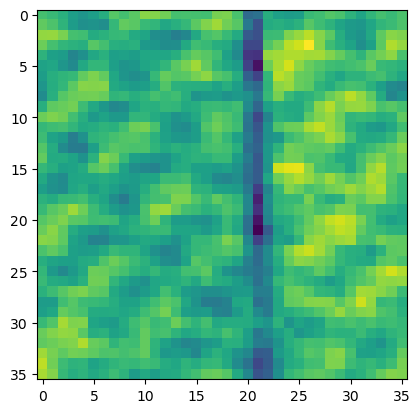

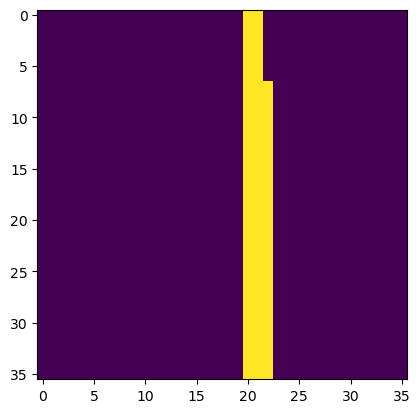

In [ ]:
image = np.load('data/images_train/well_2_patch_3.npy')
plt.imshow(image)
plt.show()

mask = np.array(y_train.loc['well_2_patch_3']).reshape(36,36)
plt.imshow(mask)
plt.show()

# Mask well : 1 à virer puis renommer 0 en 1

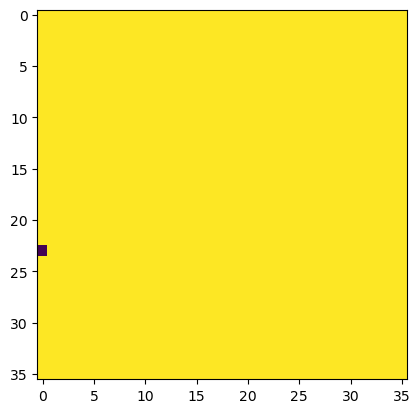

[-9.9900000e+02 -1.1246613e-01 -6.6011190e-02 ...  2.1114224e-01
  2.1895373e-01  2.3005790e-01]


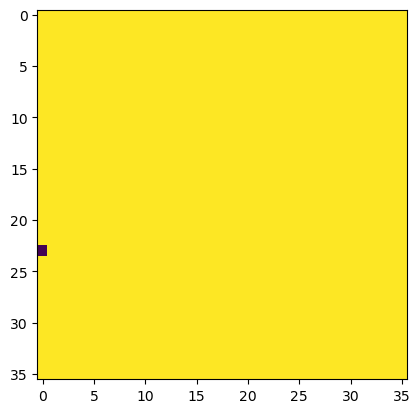

In [ ]:
# Data analysis
file_names = os.listdir('data/raw/images_train')
images = []
for img_name in file_names:
    img = np.load(os.path.join('data/raw/images_train',
                               img_name))
    if np.sum(img < -800) > 0:
        plt.imshow(img)
        plt.show()
        break
        
    images.append(img)
# flat_list_img = np.array(images).flatten()  
# print(np.unique(img))
# plt.imshow(img)
# plt.show()

In [ ]:
np.min(img)

-999.0

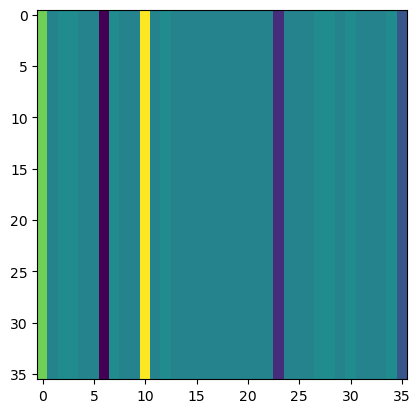

(-0.12159982,
 0.15015453,
 array([-0.12159982, -0.08601663, -0.04863465,  0.        ,  0.01086313,
         0.09190243,  0.15015453], dtype=float32))

In [ ]:
img = np.load('data/raw/images_test/well_5_patch_1957.npy')
img[img < -900] = 0
plt.figure()
plt.imshow(img)
plt.show()
np.min(img),np.max(img), np.unique(img)

In [ ]:
 # Data analysis
file_names = os.listdir('data/raw/images_test')
images_test = []
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('data/raw/images_test',
                               img_name))

    images_test.append(img)
flat_list_img_test = np.array(images_test).flatten()  
print('Number patches test set:',len(images_test))


100%|██████████| 2538/2538 [00:00<00:00, 4232.13it/s]


Number patches test set: 2538


In [ ]:
 # Data analysis
file_names = os.listdir('data/raw/images_train')
images_train = []
for img_name in tqdm(file_names):
    # print(img_name)
    img = np.load(os.path.join('data/raw/images_train',
                               img_name))

    images_train.append(img)
flat_list_img_train = np.array(images_train).flatten()  
print('Number patches train set:',len(images_train))


  0%|          | 0/9670 [00:00<?, ?it/s]

100%|██████████| 9670/9670 [00:01<00:00, 5171.07it/s]

Number patches train set: 9670


In [ ]:
# Statistics on the train images

cleaned_img = np.nan_to_num(flat_list_img_train)
print('For the training images :')
print('Mean :',np.mean(cleaned_img))
print('Std :',np.std(cleaned_img))
print('Max :',np.max(cleaned_img))
print('Min :',np.min(cleaned_img))

# Statistics on the test images

print('For the test images :')
print('Mean :',np.mean(flat_list_img_test))
print('Std :',np.std(flat_list_img_test))   
print('Max :',np.max(flat_list_img_test))   
print('Min :',np.min(flat_list_img_test))



For the training images :
Mean : -4.652891
Std : 68.02479
Max : 0.4703434
Min : -999.25
For the test images :
Mean : -9.408154
Std : 96.50173
Max : 0.33731726
Min : -999.25


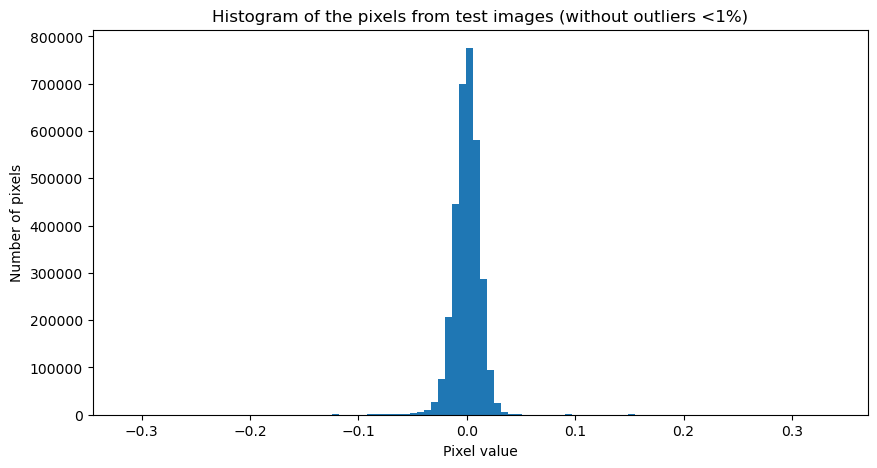

Ratio outliers pixels: 0.942 %


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(flat_list_img_test[flat_list_img_test > -100] , bins=100)
plt.title('Histogram of the pixels from test images (without outliers <1%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(flat_list_img_test[flat_list_img_test < -100])*100/len(flat_list_img_test),ndigits=3),'%')

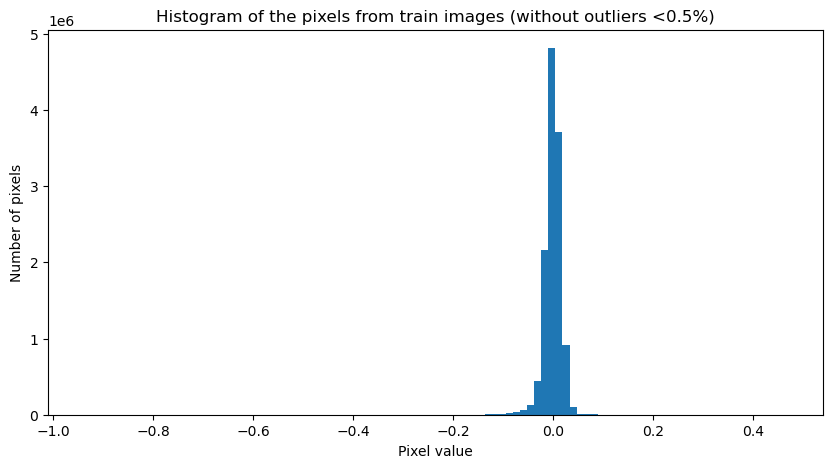

Ratio outliers pixels: 0.466 %


In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(cleaned_img[cleaned_img > -100] , bins=100)
plt.title('Histogram of the pixels from train images (without outliers <0.5%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.show()
print('Ratio outliers pixels:',round(len(cleaned_img[cleaned_img <-100])*100/len(cleaned_img),ndigits=3),'%')

## Dataset and dataloaders

In [ ]:
corro_seg = CorroSeg('data', 'y_train.csv', shuffle = True,
                 batch_size = 1, valid_ratio = 0.1, transform_img=None, transform_mask=None, 
                 transform_test=None, test_params={'batch_size': 1, 'shuffle': False})

train_data, valid_data, test_data = corro_seg.get_datasets()
train_dataloader, valid_dataloader, test_dataloader = corro_seg.get_loaders()


In [ ]:
print(len(train_data), len(valid_data), len(test_data))
print(len(train_dataloader), len(valid_dataloader), len(test_dataloader))

8397 933 2538
8397 933 2538


In [ ]:
image, mask, well = next(iter(train_dataloader))


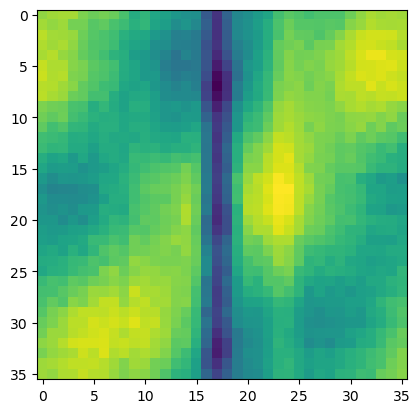

(-3.5481868,
 1.6703788,
 array([-3.5481868, -3.4076812, -3.3581643, ...,  1.6420933,  1.6548166,
         1.6703788], dtype=float32))

In [ ]:
img = torch.load('data/processed/images_train/well_14_patch_178.npy')
img = img.numpy()
plt.figure()
plt.imshow(img)
plt.show()
np.min(img),np.max(img), np.unique(img)

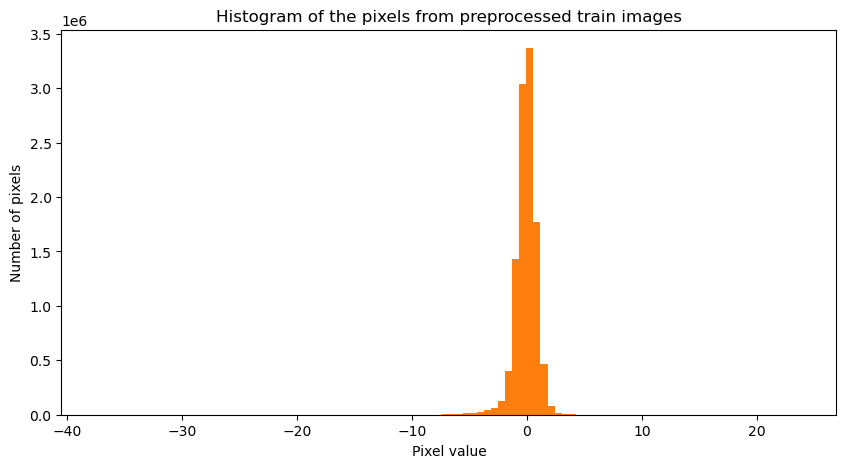

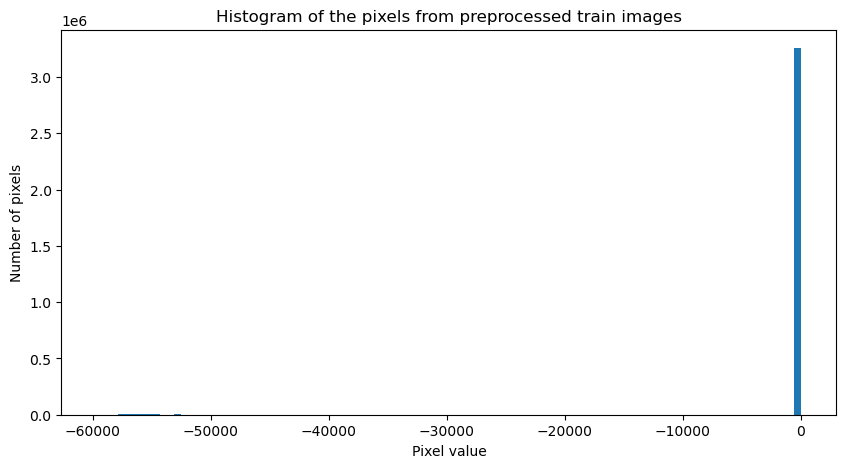

For the training images :
Mean : -0.05608637
Std : 0.9636035
Max : 23.859066
Min : -37.44029
For the test images :
Mean : -0.057334017
Std : 0.721987
Max : 18.602203
Min : -18.071201


In [ ]:
imgs = []
for img, mask, well in train_dataloader:
    imgs.append(img)
flat_imgs = np.array(imgs).flatten()

plt.figure(figsize=(10, 5)) 
plt.hist(flat_imgs [flat_imgs  > -100] , bins=100)
plt.title('Histogram of the pixels from preprocessed train images')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.hist(flat_imgs, bins=100)
plt.show()

imgs_test = []
for img,  well in test_dataloader:
    imgs_test.append(img)
flat_imgs_test = np.array(imgs_test).flatten()

plt.figure(figsize=(10, 5)) 
plt.title('Histogram of the pixels from preprocessed train images')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.hist(flat_imgs_test, bins=100)
plt.show()


print('For the training images :')
print('Mean :',np.mean(flat_imgs))
print('Std :',np.std(flat_imgs))
print('Max :',np.max(flat_imgs))
print('Min :',np.min(flat_imgs))

print('For the test images :')
print('Mean :',np.mean(flat_imgs_test[flat_imgs_test > -100]))
print('Std :',np.std(flat_imgs_test[flat_imgs_test > -100]))
print('Max :',np.max(flat_imgs_test[flat_imgs_test > -100]))
print('Min :',np.min(flat_imgs_test[flat_imgs_test > -100]))


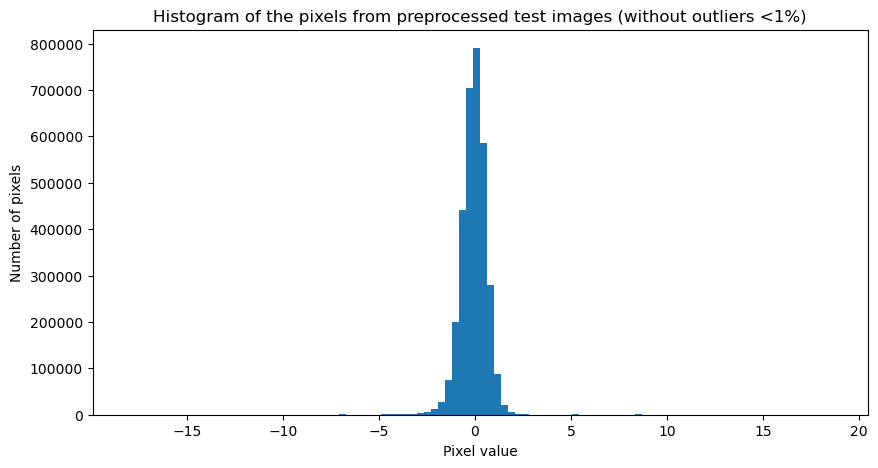

0.9415221959548201


In [ ]:
plt.figure(figsize=(10, 5)) 
plt.title('Histogram of the pixels from preprocessed test images (without outliers <1%)')
plt.xlabel('Pixel value')
plt.ylabel('Number of pixels')
plt.hist(flat_imgs_test[flat_imgs_test > -900], bins=100)
plt.show()
print(len(flat_imgs_test[flat_imgs_test < -900])/len(flat_imgs_test)*100)

### Baseline

In [24]:
folder_path = '/Users/Hippolyte/Desktop/MVA/Mallat/ENS-data-challenge-CorroSeg/data/processed/images_train'  


y_train_processed=pd.read_csv('data/processed/y_train.csv',index_col=0) #Table with index being the name of the patch

n = len(y_train_processed)
mean_0 = 0
mean_1 = 0

for i, row in y_train_processed.iterrows():

    mask = np.array(row).reshape(36,36)
    image = torch.load(os.path.join(folder_path,i+'.npy')).numpy()

    mean_1 += np.mean(np.multiply(image,mask))/n
    mean_0 += np.mean(np.multiply(image,-(mask - 1)))/n
    
print('Mean value of pixel with 0 in the mask :',mean_0)
print('Mean value of pixel with 1 in the mask :',mean_1)


Mean value of pixel with 0 in the mask : 0.051826294455344854
Mean value of pixel with 1 in the mask : -0.10791331334791456


In [33]:
tresh = (mean_0 + mean_1)/2
print('Threshold :',tresh)

folder_path = '/Users/Hippolyte/Desktop/MVA/Mallat/ENS-data-challenge-CorroSeg/data/processed/images_test'  
file_names = os.listdir(folder_path)

predictions = {}

for img_name in tqdm(file_names):
    img = torch.load(os.path.join(folder_path,img_name)).numpy()
    predict = np.zeros((36*36))
    if img[img > -100].all():
        predict = ((img<tresh)*1).flatten()
        
    predictions[img_name.replace('.npy','')] = predict

pd.DataFrame.from_dict(predictions, orient='index', dtype='int').to_csv('/Users/Hippolyte/Desktop/MVA/Mallat/ENS-data-challenge-CorroSeg/data/baseline_trs_pred.csv')


Threshold : -0.02804350944628485


100%|██████████| 2538/2538 [00:00<00:00, 5368.62it/s]


## Creation of the submission file

In [ ]:
img_save_dir = '/data/predictions'
masks = {}
for img_name in tqdm(os.listdir(img_save_dir)):
    if img_name in masks.keys():
        continue
    if '.npy' not in img_name:
        continue
    mask = np.load(img_name)
    # mask_tsh = (mask>0.5)*1
    masks[img_name] = mask.flatten()

pd.DataFrame(masks, dtype='int').to_csv('/data/pred.csv')